In [1]:
import torch, time, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-fa-acrobot/'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, arrange_data
from nn_models import MLP, PSD, MatrixNet
from symoden import SymODEN_T
from utils import L2_loss, from_pickle
import imageio


In [2]:
DPI = 600
FORMAT = 'pdf'
LINE_WIDTH = 2

def get_args():
    return {'num_angle': 2,
         'nonlinearity': 'tanh',
         'name': 'acrobot',
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 4,
         'gpu': 0,
         'solver': 'rk4'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

args = ObjectView(get_args())



 ## Load models

In [3]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
def get_model(args, baseline, structure, naive, damping, num_points):
    M_net = PSD(2*args.num_angle, 400, args.num_angle).to(device)
    g_net = MatrixNet(2*args.num_angle, 300, 4, shape=(2,2)).to(device)
    if structure == False:
        if naive and baseline:
            raise RuntimeError('argument *baseline* and *naive* cannot both be true')
        elif naive:
            input_dim = 3 * args.num_angle + 1
            output_dim = 3 * args.num_angle
            nn_model = MLP(input_dim, 1200, output_dim, args.nonlinearity).to(device)
            model = SymODEN_T(args.num_angle, H_net=nn_model, device=device, baseline=baseline, naive=naive, u_dim=2)
        elif baseline:
            input_dim = 3 * args.num_angle + 1
            output_dim = 2 * args.num_angle
            nn_model = MLP(input_dim, 800, output_dim, args.nonlinearity).to(device)
            model = SymODEN_T(args.num_angle, H_net=nn_model, M_net=M_net, device=device, baseline=baseline, naive=naive, u_dim=2)
        else:
            input_dim = 3 * args.num_angle
            output_dim = 1
            nn_model = MLP(input_dim, 600, output_dim, args.nonlinearity).to(device)
            model = SymODEN_T(args.num_angle, H_net=nn_model, M_net=M_net, g_net=g_net, device=device, baseline=baseline, naive=naive, u_dim=2)
    elif structure == True and baseline ==False and naive==False:
        V_net = MLP(2*args.num_angle, 300, 1).to(device)
        model = SymODEN_T(args.num_angle, M_net=M_net, V_net=V_net, g_net=g_net, device=device, baseline=baseline, structure=True, u_dim=2).to(device)
    else:
        raise RuntimeError('argument *structure* is set to true, no *baseline* or *naive*!')

    if naive:
        label = '-naive_ode'
    elif baseline:
        label = '-baseline_ode'
    else:
        label = '-hnn_ode'
    struct = '-struct' if structure else ''
    path = '{}/{}{}{}-{}-p{}.tar'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    model.load_state_dict(torch.load(path, map_location=device))
    path = '{}/{}{}{}-{}-p{}-stats.pkl'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    stats = from_pickle(path)
    return model, stats

symoden_ode_struct_model, symoden_ode_struct_stats = get_model(args, baseline=False, structure=True, naive=False, damping=False, num_points=args.num_points)



In [4]:
# time info for simualtion
time_step = 400 ; n_eval = 400
t_span = [0,time_step*0.05]
t_linspace_true = np.linspace(t_span[0], time_step, time_step)*0.05
t_linspace_model = np.linspace(t_span[0], t_span[1], n_eval)
# angle info for simuation
q10 = 0.0 ; q20 = 0.0
u10 = 0.0 ; u20 = 0.0

# record video
import gym
from gym import wrappers
env = gym.make('My_FA_Acrobot-v0')
env = gym.wrappers.Monitor(env, './videos/' + 'acrobot-fa' + '/', force=True) # , video_callable=lambda x: True, force=True

env.reset()
env.env.state = np.array([q10, q20, 0.0, 0.0], dtype=np.float32)
obs = env.env._get_ob()
y = torch.tensor([obs[0], obs[2], obs[1], obs[3], obs[4], obs[5], u10, u20], requires_grad=True, device=device, dtype=torch.float32).view(1, 8)

t_eval = torch.linspace(t_span[0], t_span[1], n_eval).to(device)

y_traj = []
y_traj.append(y)
frames = []
for i in range(len(t_eval)-1):
    frames.append(env.render(mode='rgb_array'))

    cos_q_sin_q, q_dot, u = torch.split(y, [4, 2, 2], dim=1)
    V_q = symoden_ode_struct_model.V_net(cos_q_sin_q)
    dV = torch.autograd.grad(V_q, cos_q_sin_q)[0]
    dVdcos_q, dVdsin_q= torch.chunk(dV, 2, dim=1)
    cos_q, sin_q = torch.chunk(cos_q_sin_q, 2,dim=1)
    dV_q = - dVdcos_q * sin_q + dVdsin_q * cos_q # (1, 2)
    g_q = symoden_ode_struct_model.g_net(cos_q_sin_q) #(1, 2, 2)
    # H, dH = symoden_ode_struct_model.get_H(y)
    # dHdcos_q, dHdsin_q, dHdp= torch.split(dH, [2, 2, 2], dim=1)

    g_q_T = torch.transpose(g_q, 1, 2)
    inv_g_g_T = torch.inverse(torch.matmul(g_q, g_q_T))
    g_T_inv_g_g_T = torch.matmul(g_q_T, inv_g_g_T)

    energy_shaping = 2 * dV_q.T
    damping_injection = -1 * q_dot.T

    u = torch.matmul(g_T_inv_g_g_T, energy_shaping+damping_injection)
    u = u.squeeze().detach().cpu().numpy()

    obs, _, _, _ = env.step(u)
    y = torch.tensor([obs[0], obs[2], obs[1], obs[3], obs[4], obs[5], u[0], u[1]], requires_grad=True, device=device, dtype=torch.float32).view(1, 8)

    y_traj.append(y)

env.close()
# imageio.mimsave('./videos/acrobot-fa/acrobot-fa.gif', frames, duration=0.02)

y_traj = torch.stack(y_traj).view(-1, 8).detach().cpu().numpy()



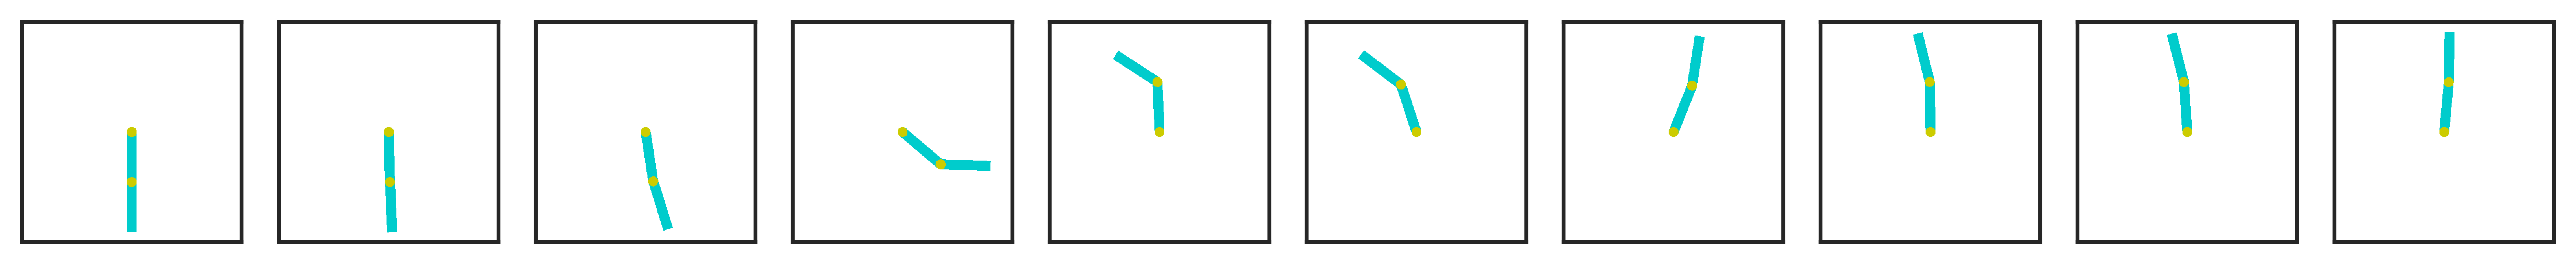

In [5]:
with plt.style.context("seaborn-white"):
    fig = plt.figure(figsize=(12, 1.3), dpi=DPI)
    plt.rcParams["axes.grid"] = False
    ax = plt.subplot(1, 10, 1)
    ax.imshow(frames[0])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 2)
    ax.imshow(frames[20])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 3)
    ax.imshow(frames[40])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 4)
    ax.imshow(frames[60])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 5)
    ax.imshow(frames[80])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 6)
    ax.imshow(frames[100])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 7)
    ax.imshow(frames[120])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 8)
    ax.imshow(frames[140])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 9)
    ax.imshow(frames[160])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 10)
    ax.imshow(frames[180])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

    plt.tight_layout()

    fig.subplots_adjust(hspace=0, wspace=0)

    # fig.savefig('{}/fig-fa-acrobot-frame.{}'.format(args.fig_dir, FORMAT))


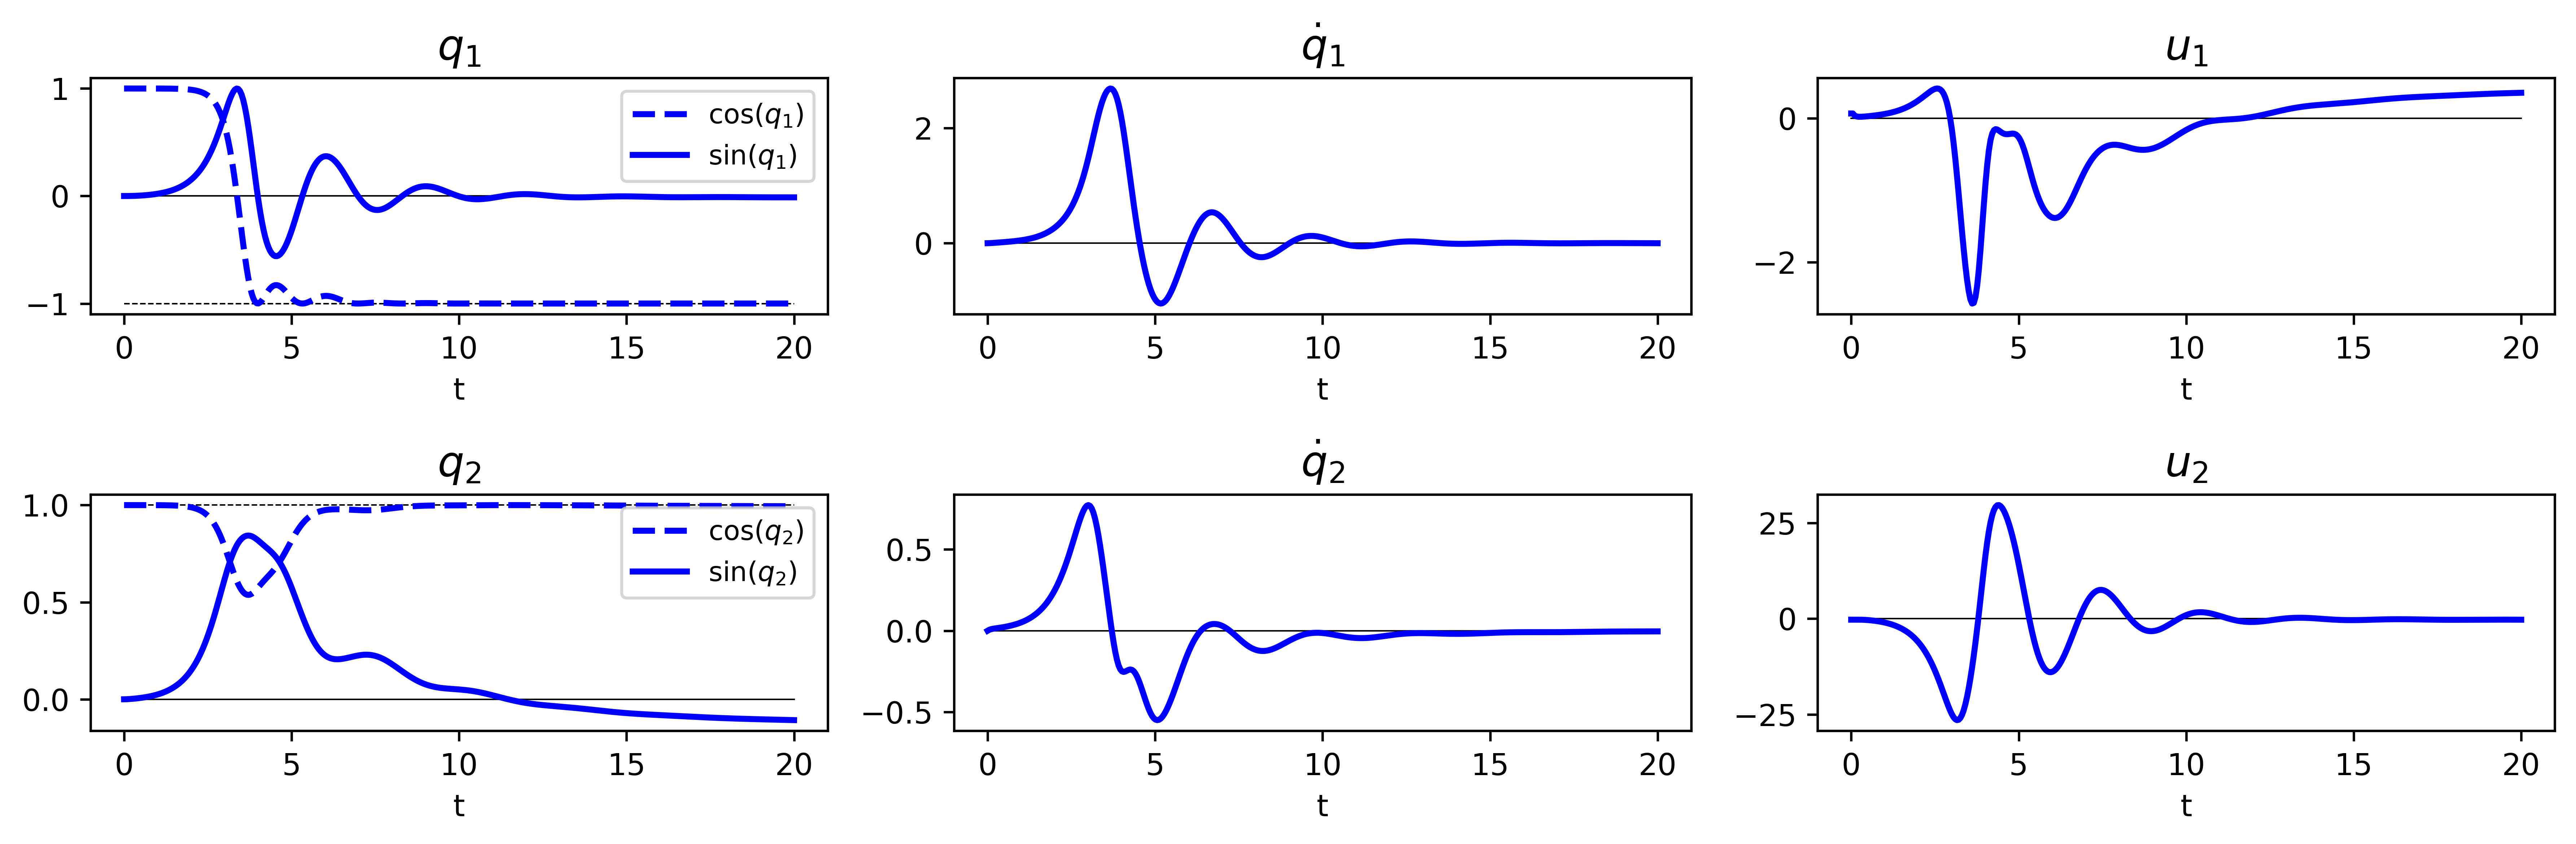

In [6]:
y_traj[0, 6] = y_traj[1, 6]
y_traj[0, 7] = y_traj[1, 7]


fig = plt.figure(figsize=[12, 4], dpi=DPI)
plt.subplot(2, 3, 1)
plt.plot(t_eval.numpy(), -1 * np.ones_like(t_eval.numpy()), 'k--', linewidth=0.5)
plt.plot(t_eval.numpy(), 0 * np.ones_like(t_eval.numpy()), 'k-', linewidth=0.5)
plt.plot(t_eval.numpy(), y_traj[:, 0], 'b--', label=r"$\cos(q_1)$", linewidth=LINE_WIDTH)
plt.plot(t_eval.numpy(), y_traj[:, 2], 'b-', label=r"$\sin(q_1)$", linewidth=LINE_WIDTH)
plt.title("$q_1$", fontsize=14)
plt.xlabel('t')
plt.legend(fontsize=9)

plt.subplot(2, 3, 4)
plt.plot(t_eval.numpy(), 1 * np.ones_like(t_eval.numpy()), 'k--', linewidth=0.5)
plt.plot(t_eval.numpy(), 0 * np.ones_like(t_eval.numpy()), 'k-', linewidth=0.5)
plt.plot(t_eval.numpy(), y_traj[:, 1], 'b--', label=r"$\cos(q_2)$", linewidth=LINE_WIDTH)
plt.plot(t_eval.numpy(), y_traj[:, 3], 'b-', label=r"$\sin(q_2)$", linewidth=LINE_WIDTH)
plt.title("$q_2$", fontsize=14)
plt.xlabel('t')
plt.legend(fontsize=9)

plt.subplot(2, 3, 2)
plt.plot(t_eval.numpy(), 0 * np.ones_like(t_eval.numpy()), 'k-', linewidth=0.5)
plt.plot(t_eval.numpy(), y_traj[:, 4], color='b', linewidth=LINE_WIDTH)
plt.title("$\dot{q}_1$", fontsize=14)
plt.xlabel('t')

plt.subplot(2, 3, 5)
plt.plot(t_eval.numpy(), 0 * np.ones_like(t_eval.numpy()), 'k-', linewidth=0.5)
plt.plot(t_eval.numpy(), y_traj[:, 5], color='b', linewidth=LINE_WIDTH)
plt.title("$\dot{q}_2$", fontsize=14)
plt.xlabel('t')

plt.subplot(2, 3, 3)
plt.plot(t_eval.numpy(), 0 * np.ones_like(t_eval.numpy()), 'k-', linewidth=0.5)
plt.plot(t_eval.numpy(), y_traj[:, 6], color='b', linewidth=LINE_WIDTH)
plt.title("$u_1$", fontsize=14)
plt.xlabel('t')

plt.subplot(2, 3, 6)
plt.plot(t_eval.numpy(), 0 * np.ones_like(t_eval.numpy()), 'k-', linewidth=0.5)
plt.plot(t_eval.numpy(), y_traj[:, 7], color='b', linewidth=LINE_WIDTH)
plt.title("$u_2$", fontsize=14)
plt.xlabel('t')

plt.tight_layout()
# fig.savefig('{}/fig-fa-acrobot-ctrl.{}'.format(args.fig_dir, FORMAT))
